In [37]:
import sf_quant as sf
import polars as pl
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
start = dt.date(1996, 1, 1)
end = dt.date(2024, 12, 31)

columns = [
    'date',
    'barrid',
    'ticker',
    'price',
    'return',
    'market_cap'
]

data = sf.data.load_assets(
    start=start,
    end=end,
    in_universe=True,
    columns=columns
)

data

date,barrid,ticker,price,return,market_cap
date,str,str,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.1595,6.006157e8
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.9585,6.0865392e8
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.1582,6.0769086e8
2013-08-05,"""USA06Z1""","""MDXG""",6.45,2.2187,6.211737e8
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-2.4806,6.0576474e8
…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,2.5872,3.5976e9
2024-12-26,"""USBQOR1""","""ECG""",73.61,4.293,3.7521e9
2024-12-27,"""USBQOR1""","""ECG""",69.85,-5.108,3.5604e9


In [39]:
momentum = (
    data
    .with_columns(
        pl.col('return').truediv(100)
    )
    .with_columns(
        pl.col('return').log1p().alias('log_return')
    )
    .sort('barrid', 'date')
    .with_columns(
        pl.col('log_return').rolling_sum(window_size=230).over('barrid').alias('momentum')
    )
    .with_columns(
        pl.col('momentum').shift(22).over('barrid')
    )
)

momentum

date,barrid,ticker,price,return,market_cap,log_return,momentum
date,str,str,f64,f64,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.001595,6.006157e8,-0.001596,null
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.009585,6.0865392e8,0.009539,null
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.001582,6.0769086e8,-0.001583,null
2013-08-05,"""USA06Z1""","""MDXG""",6.45,0.022187,6.211737e8,0.021944,null
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-0.024806,6.0576474e8,-0.025119,null
…,…,…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,0.025872,3.5976e9,0.025543,null
2024-12-26,"""USBQOR1""","""ECG""",73.61,0.04293,3.7521e9,0.042034,null
2024-12-27,"""USBQOR1""","""ECG""",69.85,-0.05108,3.5604e9,-0.052431,null


In [40]:
price_filter = (
    momentum
    .sort('barrid', 'date')
    .with_columns(
        pl.col('price').shift(1).over('barrid').alias('price_lag')
    )
    .filter(
        pl.col('price_lag').gt(5),
        pl.col('momentum').is_not_null()
    )
    .sort('barrid', 'date')
)

price_filter

date,barrid,ticker,price,return,market_cap,log_return,momentum,price_lag
date,str,str,f64,f64,f64,f64,f64,f64
2014-07-30,"""USA06Z1""","""MDXG""",7.1,0.009957,7.410696e8,0.009908,0.101525,7.03
2014-07-31,"""USA06Z1""","""MDXG""",6.91,-0.026761,7.2123816e8,-0.027126,0.124505,7.1
2014-08-01,"""USA06Z1""","""MDXG""",6.81,-0.014472,7.1080056e8,-0.014578,0.167176,6.91
2014-08-04,"""USA06Z1""","""MDXG""",7.08,0.039648,7.3898208e8,0.038882,0.159344,6.81
2014-08-05,"""USA06Z1""","""MDXG""",7.05,-0.004237,7.358508e8,-0.004246,0.14279,7.08
…,…,…,…,…,…,…,…,…
2024-12-27,"""USBPJV1""","""NLOP""",30.81,-0.019414,4.5553e8,-0.019605,0.527437,31.42
2024-12-30,"""USBPJV1""","""NLOP""",31.08,0.008763,4.5952e8,0.008725,0.522813,30.81
2024-12-31,"""USBPJV1""","""NLOP""",31.21,0.004183,4.6144e8,0.004174,0.552793,31.08


In [41]:
n_bins = 10
labels = [str(i) for i in range(n_bins)]

momentum_bins = (
    price_filter
    .with_columns(
        pl.col('momentum').qcut(n_bins, labels=labels).over('date').alias('bin')
    )
    .drop_nulls('momentum')
)

momentum_bins

date,barrid,ticker,price,return,market_cap,log_return,momentum,price_lag,bin
date,str,str,f64,f64,f64,f64,f64,f64,cat
2014-07-30,"""USA06Z1""","""MDXG""",7.1,0.009957,7.410696e8,0.009908,0.101525,7.03,"""4"""
2014-07-31,"""USA06Z1""","""MDXG""",6.91,-0.026761,7.2123816e8,-0.027126,0.124505,7.1,"""4"""
2014-08-01,"""USA06Z1""","""MDXG""",6.81,-0.014472,7.1080056e8,-0.014578,0.167176,6.91,"""5"""
2014-08-04,"""USA06Z1""","""MDXG""",7.08,0.039648,7.3898208e8,0.038882,0.159344,6.81,"""5"""
2014-08-05,"""USA06Z1""","""MDXG""",7.05,-0.004237,7.358508e8,-0.004246,0.14279,7.08,"""5"""
…,…,…,…,…,…,…,…,…,…
2024-12-27,"""USBPJV1""","""NLOP""",30.81,-0.019414,4.5553e8,-0.019605,0.527437,31.42,"""8"""
2024-12-30,"""USBPJV1""","""NLOP""",31.08,0.008763,4.5952e8,0.008725,0.522813,30.81,"""8"""
2024-12-31,"""USBPJV1""","""NLOP""",31.21,0.004183,4.6144e8,0.004174,0.552793,31.08,"""9"""


In [45]:
momentum_portfolios = (
    momentum_bins
    .group_by('date', 'bin')
    .agg(
        pl.col('return').mean()
    )
    .sort('bin')
    .pivot(index='date', on='bin', values='return')
    .sort('date')
    .with_columns(
        pl.col('9').sub('0').alias('spread')
    )
)

momentum_portfolios

date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1996-12-27,-0.00093,0.002869,0.003399,0.004531,0.003898,0.006065,0.002896,0.00353,0.003709,-0.000897,0.000033
1996-12-30,-0.008752,-0.002137,-0.001613,0.000988,0.003743,0.003316,0.002553,0.002097,0.004754,0.000174,0.008927
1996-12-31,0.011733,0.003781,0.000045,0.000151,0.001242,0.001349,0.00415,-0.001242,-0.001576,0.004902,-0.006831
1997-01-02,0.00753,-0.001875,-0.004577,-0.007111,-0.006728,-0.007624,-0.00929,-0.011045,-0.013618,-0.017719,-0.025249
1997-01-03,0.018497,0.013244,0.008077,0.007845,0.006075,0.006623,0.006741,0.009066,0.010573,0.012844,-0.005653
…,…,…,…,…,…,…,…,…,…,…,…
2024-12-24,0.007357,0.007633,0.008055,0.007497,0.007919,0.007974,0.008316,0.009136,0.011663,0.013276,0.005919
2024-12-26,0.017455,0.008819,0.006301,0.006043,0.003854,0.004201,0.003957,0.005329,0.007306,0.010651,-0.006805
2024-12-27,-0.014529,-0.012441,-0.010328,-0.011024,-0.010892,-0.012319,-0.011748,-0.013104,-0.014801,-0.020485,-0.005956


In [72]:
momentum_returns = (
    momentum_portfolios
    .unpivot(index='date', variable_name='bin', value_name='return')
    .with_columns(
        pl.col('return').log1p().cum_sum().over('bin').alias('cumulative_log_return')
    )
    .with_columns(
        pl.col('return', 'cumulative_log_return').mul(100)
    )
    .sort('bin', 'date')
)

momentum_returns

date,bin,return,cumulative_log_return
date,str,f64,f64
1996-12-27,"""0""",-0.092957,-0.093
1996-12-30,"""0""",-0.875242,-0.972095
1996-12-31,"""0""",1.173321,0.194396
1997-01-02,"""0""",0.752957,0.944533
1997-01-03,"""0""",1.849692,2.777326
…,…,…,…
2024-12-24,"""spread""",0.591908,231.967453
2024-12-26,"""spread""",-0.68046,231.284667
2024-12-27,"""spread""",-0.595633,230.687252


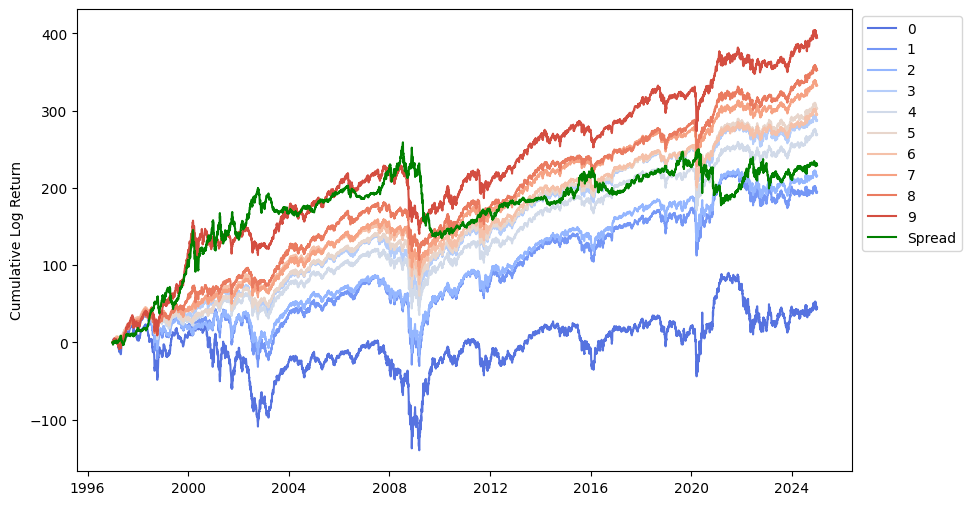

In [73]:
momentum_returns_wide = (
    momentum_returns
    .sort('bin')
    .pivot(index='date', on='bin', values='cumulative_log_return')
)

plt.figure(figsize=(10, 6))

colors = sns.color_palette('coolwarm', 10)

for label, color in zip(labels, colors):
    sns.lineplot(momentum_returns_wide, x='date', y=label, color=color, label=label)

sns.lineplot(momentum_returns_wide, x='date', y='spread', color='green', label='Spread')

plt.xlabel(None)
plt.ylabel('Cumulative Log Return')

plt.legend(title='Portfolio')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right')

plt.show()

In [81]:
pl.Config.set_tbl_rows(11)

(
    momentum_returns
    .group_by('bin')
    .agg(
        pl.col('return').mean().mul(252).alias('average_return'),
        pl.col('return').std().mul(pl.lit(252).sqrt()).alias('volatility')
    )
    .with_columns(
        pl.col('average_return').truediv('volatility').alias('sharpe')
    )
)

bin,average_return,volatility,sharpe
str,f64,f64,f64
"""0""",6.818235,32.342238,0.210815
"""1""",10.397221,26.226243,0.396443
"""2""",10.470943,23.55103,0.444607
"""3""",12.722501,22.111946,0.575368
"""4""",11.806227,20.929358,0.564099
"""5""",12.874372,20.257755,0.635528
"""6""",12.533043,19.922743,0.629082
"""7""",13.91837,20.127192,0.691521
"""8""",14.882553,21.298423,0.698763
